# Test validity step 1 : $P(\eta | ...) \propto \eta^t \left( C_{approx}^{1/2} (C_{approx}^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1}) C_{approx}^{1/2} \right)^{-1} \eta$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.io.fits as fits
import scipy
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import jax.lax as jlx

import micmac as micmac

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
# from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# from get_freq_maps_SO_64_lower_noise import *
# from get_freq_maps_LiteBIRD_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


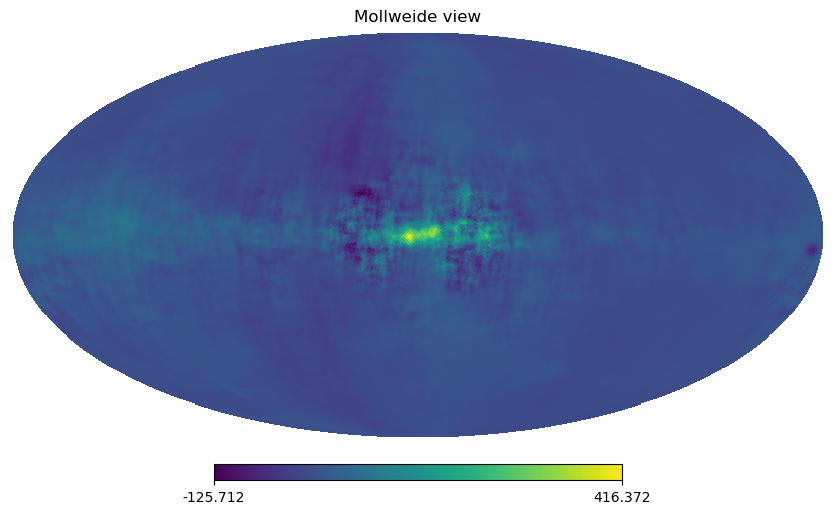

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:

working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v5/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

# path_toml_file = directory_toml_file + 'biased_full_chain_v1a.toml'
path_toml_file = directory_toml_file + 'biased_full_chain_v1c.toml'

MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)


In [6]:
Fisher_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/Fisher_matrix_SO_SAT_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt'

Fisher_matrix = np.loadtxt(Fisher_path)

minimum_std_Fisher = scipy.linalg.sqrtm(np.linalg.inv(Fisher_matrix))
minimum_std_Fisher_diag = np.diag(minimum_std_Fisher)

len_pos_special_freqs = len(MICMAC_sampler_obj.pos_special_freqs)
col_dim_B_f = MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs

step_size_B_f = np.zeros((col_dim_B_f,2))
step_size_B_f[:,0] = minimum_std_Fisher_diag[:MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs]
step_size_B_f[:,1] = minimum_std_Fisher_diag[MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs:2*(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs)]


In [7]:
path_mask = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

apod_mask = hp.ud_grade(hp.read_map(path_mask),nside_out=MICMAC_sampler_obj.nside)
mask = np.copy(apod_mask)
mask[apod_mask>0] = 1

# mask = np.ones(MICMAC_sampler_obj.npix)

MICMAC_sampler_obj.mask = mask

In [8]:
%%time

freq_inverse_noise = MICMAC_sampler_obj.freq_inverse_noise

freq_inverse_noise_masked = np.zeros((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.npix))

nb_pixels_mask = int(mask.sum())
freq_inverse_noise_masked[:,:,mask!=0] = np.repeat(freq_inverse_noise.ravel(order='F'), nb_pixels_mask).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_frequencies,nb_pixels_mask), order='C')


CPU times: user 9.45 ms, sys: 1.17 ms, total: 10.6 ms
Wall time: 9.82 ms


In [9]:
MICMAC_sampler_obj.freq_inverse_noise = freq_inverse_noise_masked

In [10]:
MICMAC_sampler_obj.freq_inverse_noise[:,:,mask==0]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 

In [11]:
input_freq_maps, _, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

input_freq_maps_masked = input_freq_maps*mask

# Re-Defining the data if needed
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]


theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)#[partial_indices_polar,:]
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)#[partial_indices_polar,:]


c_ell_approx = np.zeros((3,MICMAC_sampler_obj.lmax+1))
c_ell_approx[0,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[0,:]
c_ell_approx[1,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[1,:]

# Params mixing matrix
init_mixing_matrix_obj = micmac.InitMixingMatrix(MICMAC_sampler_obj.frequency_array, MICMAC_sampler_obj.number_components, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)
exact_params_mixing_matrix = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(MICMAC_sampler_obj.frequency_array, MICMAC_sampler_obj.number_components, exact_params_mixing_matrix, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(MICMAC_sampler_obj.freq_inverse_noise), mixing_matrix_sampled)

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [12]:
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[MICMAC_sampler_obj.lmin:,...]

In [13]:
red_cov_approx_matrix.shape

(127, 2, 2)

In [14]:
lmax = MICMAC_sampler_obj.lmax
n_iter = MICMAC_sampler_obj.n_iter
lmin = MICMAC_sampler_obj.lmin
nstokes = MICMAC_sampler_obj.nstokes
nside = MICMAC_sampler_obj.nside
number_frequencies = MICMAC_sampler_obj.number_frequencies
npix = MICMAC_sampler_obj.npix


In [15]:
jax_key_PNRG = jax.random.PRNGKey(MICMAC_sampler_obj.seed+10)

In [16]:
%%time

map_random_x = None
map_random_y = None
eta_maps = MICMAC_sampler_obj.get_sampling_eta_v2(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


Recalculating x !
Recalculating y !
CPU times: user 5.37 s, sys: 993 ms, total: 6.37 s
Wall time: 2.53 s


In [17]:
jitted_sampling_eta = jax.jit(MICMAC_sampler_obj.get_sampling_eta_v2, static_argnames=['suppress_low_modes'])

In [18]:
%%time
eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


Recalculating x !
Recalculating y !
CPU times: user 2.05 s, sys: 373 ms, total: 2.43 s
Wall time: 889 ms


In [19]:
%%time
eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


CPU times: user 500 ms, sys: 60 ms, total: 561 ms
Wall time: 91.4 ms


In [20]:
# %%time
# eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


In [21]:
# %%time
# eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


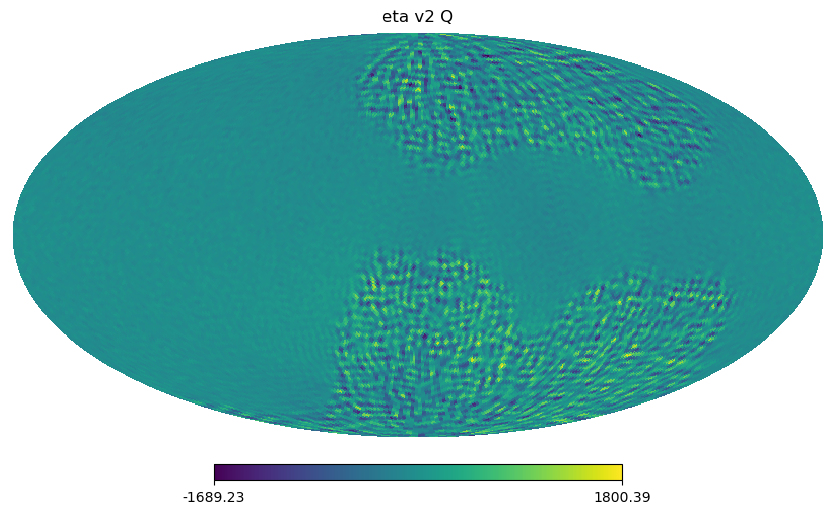

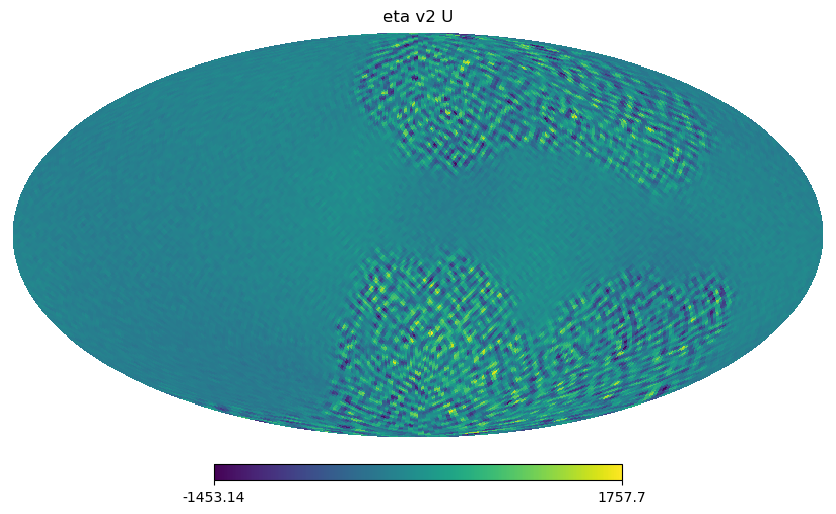

In [22]:
hp.mollview(eta_maps[0], title='eta v2 Q')
hp.mollview(eta_maps[1], title='eta v2 U')

In [23]:
eta_maps_extended = np.vstack([np.zeros_like(eta_maps[0]), eta_maps])
c_ells_eta = hp.anafast(eta_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [24]:
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, MICMAC_sampler_obj.lmax)[0,0,lmin:]

red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))


In [25]:
red_cov_approx_matrix_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix))
red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)

red_cl_noise_harm_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cl_noise_harm)
red_cl_noise_harm_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cl_noise_harm))

analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + np.linalg.pinv(red_cl_noise_harm), red_cov_approx_matrix_sqrt)
analytical_eta_term_2 = np.zeros_like(c_ell_approx)
analytical_eta_term_2[:,lmin:] = micmac.get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov)


In [26]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [27]:
fksy = mask.sum()/mask.size
# fksy = 1
print('fksy = ', fksy)

fksy =  0.3468424479166667


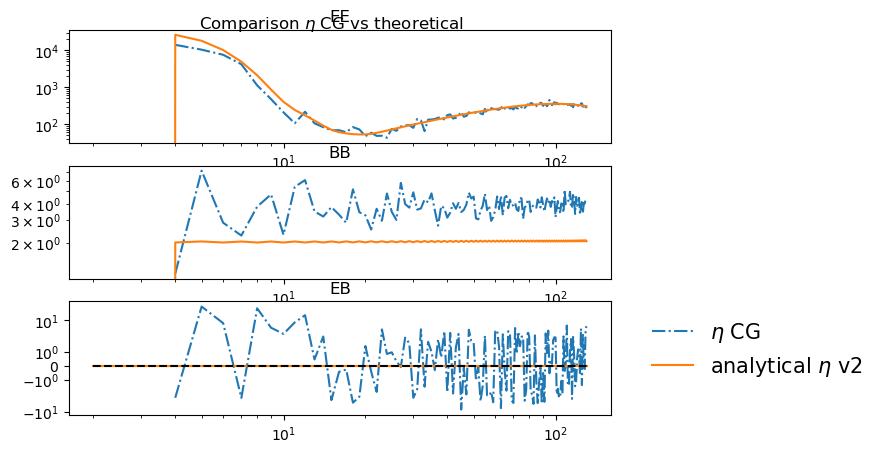

In [28]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(c_ell_approx.shape[1]) + lmin

plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison $\eta$ CG vs theoretical", y=0.91)

for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])

    # plt.plot(ell_arange, c_ell_approx.T[:,j], label='c_ell_approx')
    plt.plot(ell_arange[lmin:], c_ells_eta[j,:]/fksy, '-.', label=r"$\eta$ CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_overrel[j,:]/fksy, '-.', label=r"Overrelax $\eta$ CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_v1[j,:]/fksy, '-.', label=r"$\eta$ v1 CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_overrel_v1[j,:]/fksy, '-.', label=r"Overrelax v1 $\eta$ CG")

    # plt.plot(ell_arange, analytical_eta_term[j,:], '-.', label=r"analytical $\eta$")
    plt.plot(ell_arange, analytical_eta_term_2[j,:], label=r"analytical $\eta$ v2")
    # plt.plot(ell_arange[lmin:], 1/_cl_noise_harm, '-.', label=r"$N_c$")
    # plt.plot(ell_arange[lmin:], 1/theoretical_r0_total[j,:], label='C_approx')
    # if j < nstokes:
    #     plt.plot([ell_arange[0], ell_arange[-1]], [1,1], '--', color='black')
    # plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')


plt.show()

# Test func

In [29]:

    def get_conditional_proba_correction_likelihood_JAX_v2c(self, complete_mixing_matrix, component_eta_maps, red_cov_approx_matrix, previous_inverse=jnp.empty(0), return_inverse=False):
        """ Get conditional probability of correction term in the likelihood from the full mixing matrix

            The associated conditional probability is given by : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
            Or :
            - (eta^t C_approx^{-1/2} ( C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E) ^{-1}) C_approx^{-1/2} \eta

            Parameters
            ----------
            :param complete_mixing_matrix: full mixing matrix of dimension [component, frequencies]
            :param component_eta_maps: set of eta maps of dimension [component, npix]
            :param red_cov_approx_matrix: covariance matrice approx (C_approx) in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

            Returns
            -------
            :return: computation of correction term to the likelihood
        """

        # Building the correction term to the likelihood : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} \eta

        ## Preparing the mixing matrix and C_approx^{-1/2}
        invBtinvNB = get_inv_BtinvNB(self.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(self.nside)**2        
        red_cov_approx_matrix_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix)
        red_cov_approx_matrix_msqrt = jnp.linalg.pinv(red_cov_approx_matrix_sqrt)

        ## Preparing the operator ( C_approx^{-1} + N_c^{-1} )^{-1}
        N_c_inv = jnp.zeros_like(invBtinvNB[0,0])
        N_c_inv = N_c_inv.at[...,self.mask!=0].set(1/invBtinvNB[0,0,self.mask!=0])
        N_c_inv_repeat = jnp.repeat(N_c_inv.ravel(order='C'), self.nstokes).reshape((self.nstokes,self.npix), order='F').ravel()

        N_c_repeat = jnp.repeat(invBtinvNB[0,0].ravel(order='C'), self.nstokes).reshape((self.nstokes,self.npix), order='F').ravel()
        
        first_part_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), red_cov_approx_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter).ravel()
        
        def second_part_left(x):
            # return x.reshape((self.nstokes,self.npix))*N_c_inv
            return x*N_c_inv_repeat

        # inv_first_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), red_cov_approx_matrix_msqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter).ravel()

        func_left_term = lambda x : x.ravel() + first_part_left(second_part_left(first_part_left(x))).ravel()

        ## Computation of ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
        initial_guess = jnp.copy(component_eta_maps)

        if previous_inverse.size != 0:
            initial_guess = jnp.copy(previous_inverse)

        right_member = jnp.copy(component_eta_maps)
    
        func_lineax = lx.FunctionLinearOperator(func_left_term, jax.ShapeDtypeStruct((self.nstokes*self.npix,),jnp.float64), tags=(lx.symmetric_tag,lx.positive_semidefinite_tag))

        # mask_binary = jnp.copy(self.mask)
        # if mask_binary is None:
        #     mask_binary = jnp.ones_like(self.mask)
        # mask_to_use = jnp.repeat(mask_binary[:].ravel(order='C'), self.nstokes).reshape((self.nstokes,self.npix), order='F').ravel()

        # func_norm = lambda x : jnp.linalg.norm((x.reshape((self.nstokes,self.npix))*self.mask).ravel(),ord=2)
        # func_norm = lambda x : jnp.linalg.norm((x*mask_to_use).ravel(),ord=2)
        # func_norm = lambda x : jnp.sqrt(jnp.sum((x.reshape((self.nstokes,self.npix)))**2))
        func_norm = lambda x : jnp.linalg.norm(x,ord=2)

        # def inv_sqrt_second_part_left(x):
        #     # return x.reshape((self.nstokes,self.npix))*N_c_inv
        #     return x*jnp.sqrt(N_c_repeat)

        # precond_func = lambda x : x.ravel() - third_part_term_left(second_part_left(first_part_left(x))).ravel()
        # precond_func = lambda x : inv_sqrt_second_part_left(inv_first_part_term_left(x).ravel()).ravel()

        # precond_lineax = lx.FunctionLinearOperator(precond_func, jax.ShapeDtypeStruct((self.nstokes*self.npix,),jnp.float64), tags=(lx.symmetric_tag,lx.positive_semidefinite_tag))

        CG_obj = lx.CG(rtol=self.tolerance_CG, atol=1e-8, max_steps=self.limit_iter_cg_eta, norm=func_norm)

        time_start = time.time()
        options_dict = {"y0":initial_guess.ravel()}
        # options_dict = {"y0":initial_guess.ravel(), "precond":precond_lineax}
        
        # inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=self.tolerance_CG, atol=self.tolerance_CG, maxiter=self.limit_iter_cg_eta)
        solution = lx.linear_solve(func_lineax, right_member.ravel(), solver=CG_obj, throw=False, options=options_dict)

        inverse_term = solution.value
        print("CG-Python-0 Fluct finished with ", solution.result, solution.stats)
        ## Computation of C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
        # component_eta_maps_3 = maps_x_red_covariance_cell_JAX(inverse_term.reshape(self.nstokes,self.npix), red_cov_approx_matrix_msqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)

        # And finally eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
        # second_term_complete = jnp.einsum('sk,sk', component_eta_maps, inverse_term.reshape(self.nstokes,self.npix))
        if self.restrict_to_mask:
            central_term = self.mask
        else:
            central_term = jnp.ones_like(self.mask)
        second_term_complete = jnp.einsum('sp,p,sp', component_eta_maps, central_term, inverse_term.reshape(self.nstokes,self.npix))
        if return_inverse:
            return -(-0 + second_term_complete)/2.*jhp.nside2resol(self.nside)**2, inverse_term.reshape(self.nstokes,self.npix)
        return -(-0 + second_term_complete)/2.*jhp.nside2resol(self.nside)**2


In [30]:
    def get_conditional_proba_correction_likelihood_JAX_v2d(self, old_params_mixing_matrix, new_params_mixing_matrix, inverse_term, component_eta_maps, red_cov_approx_matrix):
        """ Get conditional probability of correction term in the likelihood from the full mixing matrix

            The associated conditional probability is given by : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
            Or :
            - (eta^t C_approx^{-1/2} ( C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E) ^{-1}) C_approx^{-1/2} \eta

            Parameters
            ----------
            :param complete_mixing_matrix: full mixing matrix of dimension [component, frequencies]
            :param component_eta_maps: set of eta maps of dimension [component, npix]
            :param red_cov_approx_matrix: covariance matrice approx (C_approx) in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

            Returns
            -------
            :return: computation of correction term to the likelihood
        """

        self._fake_mixing_matrix.update_params(old_params_mixing_matrix, jax_use=True)
        old_mixing_matrix = self._fake_mixing_matrix.get_B(jax_use=True)

        self._fake_mixing_matrix.update_params(new_params_mixing_matrix)
        new_mixing_matrix = self._fake_mixing_matrix.get_B(jax_use=True)


        ## Preparing the mixing matrix and C_approx^{-1/2}
        old_invBtinvNB = get_inv_BtinvNB(self.freq_inverse_noise, old_mixing_matrix, jax_use=True)*jhp.nside2resol(self.nside)**2
        new_invBtinvNB = get_inv_BtinvNB(self.freq_inverse_noise, new_mixing_matrix, jax_use=True)*jhp.nside2resol(self.nside)**2

        red_cov_approx_matrix_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix)

        old_N_c_inv = jnp.zeros_like(old_invBtinvNB[0,0])
        old_N_c_inv = old_N_c_inv.at[...,self.mask!=0].set(1/old_invBtinvNB[0,0,self.mask!=0])
        old_N_c_inv_repeat = jnp.repeat(old_N_c_inv.ravel(order='C'), self.nstokes).reshape((self.nstokes,self.npix), order='F').ravel()

        new_N_c_inv = jnp.zeros_like(new_invBtinvNB[0,0])
        new_N_c_inv = new_N_c_inv.at[...,self.mask!=0].set(1/new_invBtinvNB[0,0,self.mask!=0])
        new_N_c_inv_repeat = jnp.repeat(new_N_c_inv.ravel(order='C'), self.nstokes).reshape((self.nstokes,self.npix), order='F').ravel()

        first_part_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), red_cov_approx_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter).ravel()
        
        def second_part_left(x):
            return x*(new_N_c_inv_repeat-old_N_c_inv_repeat)

        func_to_apply = lambda x : first_part_left(second_part_left(first_part_left(x))).ravel()

        ## Getting new inverse
        if self.restrict_to_mask:
            central_term = self.mask
        else:
            central_term = jnp.ones_like(self.mask)

        perturbation_term = func_to_apply(inverse_term).reshape(self.nstokes,self.npix)
        previous_inverse_x_eta = inverse_term.reshape(self.nstokes,self.npix)

        # new_log_proba = jnp.einsum('sp,p,sp', component_eta_maps, central_term, previous_inverse_x_eta) - jnp.einsum('sp,p,sp', previous_inverse_x_eta, central_term, perturbation_term)
        new_log_proba = jnp.einsum('sp,p,sp', component_eta_maps - perturbation_term, central_term, previous_inverse_x_eta)
        print("First order :", jnp.einsum('sp,p,sp', component_eta_maps, central_term, previous_inverse_x_eta))
        print("Perturbation :", -jnp.einsum('sp,p,sp', perturbation_term, central_term, previous_inverse_x_eta))

        return -(-0 + new_log_proba)/2.*jhp.nside2resol(self.nside)**2


In [31]:
true_mask = mask
fake_mask = np.ones_like(mask)

# MICMAC_sampler_obj.mask = true_mask

In [32]:
MICMAC_sampler_obj.limit_iter_cg_eta = 200
MICMAC_sampler_obj.limit_iter_cg_eta = 2000

In [33]:
%%time

log_proba_0, partial_term_0 = get_conditional_proba_correction_likelihood_JAX_v2c(MICMAC_sampler_obj, mixing_matrix_sampled, eta_maps, red_cov_approx_matrix, 
                                                                                    previous_inverse=jnp.empty(0), return_inverse=True)

CG-Python-0 Fluct finished with  lineax._solution.RESULTS<> {'max_steps': 2000, 'num_steps': Array(1414, dtype=int64)}
CPU times: user 6min 56s, sys: 46.8 s, total: 7min 42s
Wall time: 1min 11s


In [38]:
# gap = np.zeros_like(step_size_B_f)
# gap[0,0] = step_size_B_f[0,0]
gap = 10*np.copy(step_size_B_f)


old_params_mixing_matrix = np.copy(mixing_matrix_sampled[1:-1,1:])
new_params_mixing_matrix = np.copy(old_params_mixing_matrix) + gap

new_mixing_matrix = np.copy(mixing_matrix_sampled)
new_mixing_matrix[1:-1,1:] = new_params_mixing_matrix


In [39]:
%%time
log_proba_1 = get_conditional_proba_correction_likelihood_JAX_v2c(MICMAC_sampler_obj, new_mixing_matrix, eta_maps, red_cov_approx_matrix, 
                                                                                    previous_inverse=partial_term_0, return_inverse=False)

In [ ]:
%%time
log_proba_2 = get_conditional_proba_correction_likelihood_JAX_v2d(MICMAC_sampler_obj, old_params_mixing_matrix, new_params_mixing_matrix, partial_term_0, eta_maps, red_cov_approx_matrix)

First order : 44424704.16038053
Perturbation : 18481.035174284687
CPU times: user 2.39 s, sys: 676 ms, total: 3.07 s
Wall time: 898 ms


In [ ]:
print("Initial log proba = ", log_proba_0)
print("New log proba 1 = ", log_proba_1)
print("New log proba 2 = ", log_proba_2)

Initial log proba =  -5678.886890793921
New log proba 1 =  -5681.278745298364
New log proba 2 =  -5681.249353535341
